<center><h1>Analyzing Gender Bias in Hiring and Implementing an Automated Resume Screening: A Data-Driven Approach</h1></center>

**Note:** For metadata details and cleaning process context, please refer to the accompanying data notebook - ***data_exploration_metadata.ipynb***.

In [54]:
%matplotlib inline

In [55]:
from IPython.display import display, HTML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [56]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Aleksandar
[nltk_data]     Stojcev\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Aleksandar
[nltk_data]     Stojcev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Aleksandar
[nltk_data]     Stojcev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [57]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

# Introduction

Gender bias in hiring has long been a subject of public concern, policy discussion, and academic inquiry. It is the tendency to prefer one gender over another - a form of unconscious bias, or implicit bias, which occurs when one individual unconsciously attributes certain attitudes and stereotypes to another person or group of people (Reiners, 2024). It is widely recognized that hiring decisions are not always based purely on merit, and concerns about unconscious bias - particularly regarding gender - have prompted calls for greater transparency and fairness in recruitment practices. While a number of studies have identified patterns of disadvantage faced by female candidates (Eagly and Karau, 2002, Moss-Racusin et al., 2012), especially in male-dominated industries and leadership positions (Isaac, Lee, & Carnes, 2009), the overall picture remains complex. Some research finds minimal or inconsistent effects, and outcomes can vary depending on context, sector, or methodology (Park & Oh, 2025). This ongoing uncertainty highlights the importance of using data-driven approaches to better understand how bias may operate in hiring, and to what extent it can be detected, measured, or even mitigated through analytical tools.

In this project, I utilize two distinct datasets to explore different aspects of the hiring process. The first dataset consists of structured hiring records, including candidate gender, education, age, years of experience, rating scores, and interview outcomes. This data is used to examine potential gender-related patterns or disparities in hiring decisions. Additionally, rating scores are analyzed to further deepen the investigation. The second dataset comprises anonymized resumes, which I use to build a simple rule-based resume screening model. Given a job description as input, the model evaluates each resume and classifies it as either a “fit” or “no fit.” Together, these analyses aim to shed light on both human and automated influences in hiring, and to assess fairness at multiple stages of the candidate selection process.

# Exploring for Gender Bias in Hiring and Rating Decisions

We begin by exploring the first dataset, which contains recruitment data including gender (our primary independent variable), hiring decision (the main dependent variable), and several additional factors that may interact with or influence the relationship between them.

In [58]:
df = pd.read_csv('C:\\Users\\Aleksandar Stojcev\\Desktop\\Tanya DE\\Data Science 2025\\FINAL PROJECT\\data\\cleaned_recruitment_data.csv')

In [59]:
df

,age,gender,education_level,experience_years,interview_score,skill_score,personality_score,hiring_decision
0,26,Female,Bachelor's,0,48,78,91,Hired
1,39,Female,PhD,12,35,68,80,Hired
2,48,Male,Bachelor's,3,20,67,13,Not Hired
3,34,Female,Bachelor's,5,36,27,70,Not Hired
4,30,Male,Bachelor's,6,23,52,85,Not Hired
...,...,...,...,...,...,...,...,...
1495,48,Male,Bachelor's,3,66,3,80,Hired
1496,27,Female,Bachelor's,10,43,97,7,Not Hired
1497,24,Female,Bachelor's,1,31,91,58,Hired
1498,48,Male,Bachelor's,4,9,37,44,Hired


## Hiring by Gender

It is worth initially examining whether the dataset, ot its own, reflects any overall gender bias in hiring decisions - without yet accounting for other variables such as age, education, or years of experience.

In [60]:
df['hiring_decision'] = df['hiring_decision'].map({'Hired': 1, 'Not Hired': 0})

In [61]:
hiring_by_gender = pd.crosstab(df['gender'], df['hiring_decision'], normalize = 'index') * 100
hiring_by_gender.columns = ['Not Hired (%)', 'Hired (%)']
hiring_by_gender.index = ['Male', 'Female']

In [62]:
hiring_by_gender

,Not Hired (%),Hired (%)
Male,69.105691,30.894309
Female,68.897638,31.102362


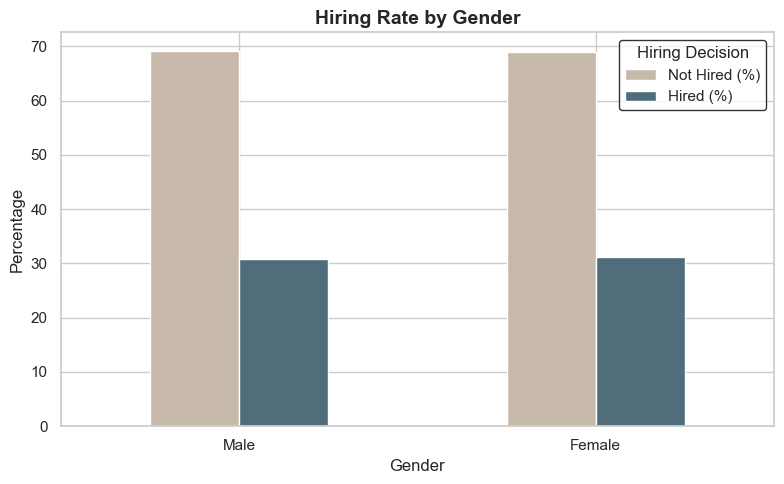

In [63]:
hiring_by_gender.plot(kind = 'bar', figsize = (8, 5), color = ['#c7b9a9', '#4f6d7a'])

plt.title('Hiring Rate by Gender', weight = 'bold', fontsize = 14)
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.xticks(rotation = 0)

plt.legend(loc = 'upper right', title = 'Hiring Decision', frameon = True, edgecolor = 'black')

plt.tight_layout()
plt.show()

The hiring rates for male and female candidates are nearly identical, with a difference of less that 0.2%. This suggests that, at the aggregate level, there is no clear evidence of gender bias in hiring decisions within this dataset.

It is important to recognize that the relationship between gender and hiring decisions may vary under different conditions. In the following subsections, we analyze whether gender bias is present across various subgroups.

### Across age groups (20-50)

An important variable that is worth investigating is age. Age on it's own creates an environment for potential bias and therefore it is interesting to investigate the interaction of age with gender and how it influences hiring decisions. Some studies suggest that young women are less often hired for better-paying jobs (Bamieh & Ziegler, 2023). Bamieh and Ziegler argue that these differences are consistent with hiring discrimination against women in their fertile age as young female jobseekers are much more likely to go on parental leave in the future, while men almost never take extended parental leave.

In [64]:
df['age_group'] = pd.cut(df['age'], bins = [19, 29, 39, 50], labels = ['<30', '30-39', '40+'])

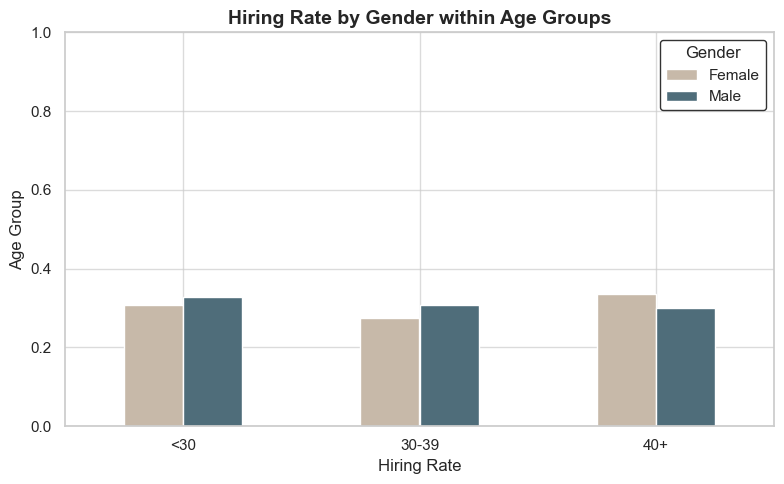

In [65]:
gender_age_hiring = (df.groupby(['age_group', 'gender'], observed = True)['hiring_decision'].mean().reset_index())

pivot_data = gender_age_hiring.pivot(index = 'age_group', columns = 'gender', values = 'hiring_decision')

fig, ax = plt.subplots(figsize = (8, 5))
pivot_data.plot(kind = 'bar', ax = ax, color = ['#c7b9a9', '#4f6d7a'])

ax.set_title('Hiring Rate by Gender within Age Groups', weight = 'bold', fontsize = 14)
ax.set_xlabel("Hiring Rate")
ax.set_ylabel("Age Group")
ax.set_ylim(0, 1)

ax.legend(title = "Gender", frameon = True, edgecolor = 'black')

ax.grid(True, alpha = 0.7)
plt.xticks(rotation = 0)

plt.tight_layout()
plt.show()

Based on the plot above, hiring rates between men and women vary slightly depending on age group. In the under 30 and 30-39 groups, men have a somwhat higher hiring rate than women. However, in the 40+ group, women have a higher hiring rate than men. Overall, the differences are not large but could suggest that gender bias in hiring may depent on the age of the candidates. This finding is consistent with a study by Ruggs, Hebl, Walker, and Fa-Kaji (2014), which found an interaction between age and gender - older male applicants were evaluated more negatively than both older female and younger male applicants.

### Across Education

Education is often a key factor in hiring decisions, as it reflects a candidate’s qualifications and potential for success. It’s important to consider whether candidates with the same level of education are evaluated differently based on gender. A study by González, Cortina, and Rodríguez (2019) found that men were favored in hiring decisions, indicating the presence of gender bias. However, this bias was reduced when women held higher qualifications, suggesting that education may help mitigate gender-based discrimination in recruitment. 

In the following subsection, we examine whether gender bias exists among candidates with different educational backgrounds, and whether certain education levels are associated with more or less equitable hiring outcomes.

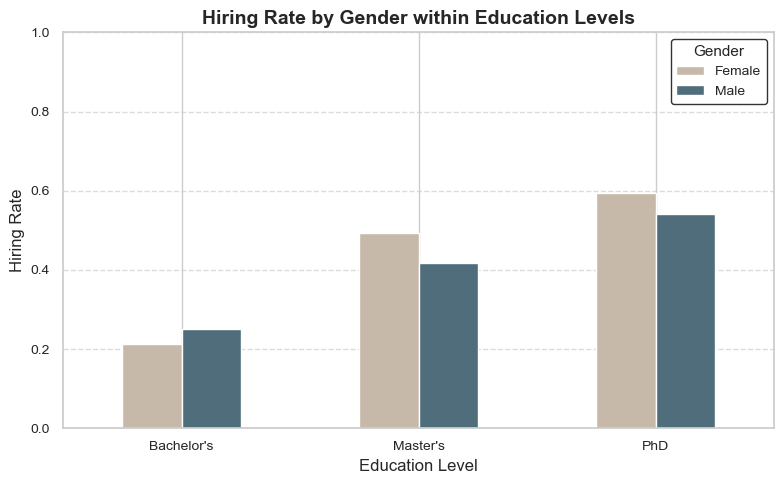

In [66]:
gender_edu_hiring = (df.groupby(['education_level', 'gender'], observed = True)['hiring_decision'].mean().reset_index())

pivot_edu = gender_edu_hiring.pivot(index = 'education_level', columns = 'gender',values = 'hiring_decision').astype(float)

fig, ax = plt.subplots(figsize = (8, 5))
pivot_edu.plot(kind = 'bar', ax = ax, color = ['#c7b9a9', '#4f6d7a'])

ax.set_title("Hiring Rate by Gender within Education Levels", fontsize = 14, weight = 'bold')
ax.set_ylabel("Hiring Rate", fontsize = 12)
ax.set_xlabel("Education Level", fontsize = 12)
ax.set_ylim(0, 1)

ax.set_axisbelow(True)
ax.grid(True, axis = 'y', linestyle = '--', alpha = 0.7)
plt.xticks(rotation = 0, fontsize = 10)
plt.yticks(fontsize = 10)

ax.legend(title = "Gender", fontsize = 10, title_fontsize = 11, frameon = True, edgecolor = 'black')

plt.tight_layout()
plt.show()


Among candidates with a Bachelor's degree, males are hired slightly more often than females. However, this trend reverses at the Master's and PhD levels, where females have higher hiring rates. This suggests that gender bias in hiring may not be uniform across education levels: there appears to be a slight male advantage at lower education levels and a slight female advantage at higher ones.

### Across Years of Experience

Undestanding how years of experiencfe influence hiring decisions is essential when investigating potential gender bias. Experience is often viewed as a key indicator of job readiness and competence, but its impact may not be the same for all candidates. In this subsection, we explore whether gender bias exists across different levels of experience, and whether men and women with similar experience are evaluated differently in hiring outcomes.

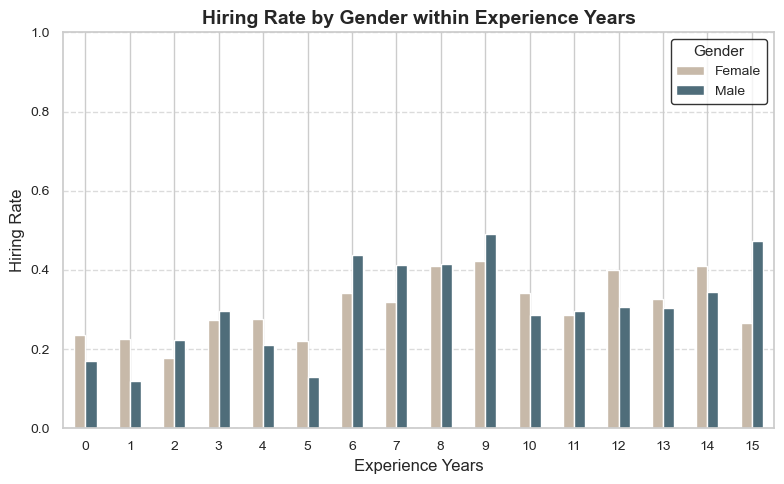

In [67]:
gender_exp_hiring = (df.groupby(['experience_years', 'gender'], observed = True)['hiring_decision'].mean().reset_index()
)

pivot_exp = gender_exp_hiring.pivot(index = 'experience_years', columns = 'gender', values = 'hiring_decision').astype(float)

fig, ax = plt.subplots(figsize = (8, 5))
pivot_exp.plot(kind = 'bar', ax = ax, color = ['#c7b9a9', '#4f6d7a'])

ax.set_title("Hiring Rate by Gender within Experience Years", fontsize = 14, weight = 'bold')
ax.set_ylabel("Hiring Rate", fontsize = 12)
ax.set_xlabel("Experience Years", fontsize = 12)
ax.set_ylim(0, 1)

ax.set_axisbelow(True)
ax.grid(True, axis = 'y', linestyle = '--', alpha = 0.7)
plt.xticks(rotation = 0, fontsize = 10)
plt.yticks(fontsize = 10)

ax.legend(title = "Gender", fontsize = 10, title_fontsize = 11, frameon = True, edgecolor = 'black')

plt.tight_layout()
plt.show()


Overall, hiring rates tend to increase with experience for both male and female candidates. However, the differences between genders are inconsistent across experience levels. In some cases, males have slightly higher hiring rates; in others, females do. Notably, at 15 years of experience, there is a visible gap in favor of male candidates, suggesting a potential area where gender-based differences may be more pronounced. Despite this, the broader pattern does not point to a clear or consistent gender bias in hiring decisions when broken down by years of experience.

## Rating by Gender across Groups

Gender bias can sometimes emerge even before the final hiring decision is made. To reach that stage, candidates must first be perceived positively by the hiring team. And while hard skills are important, they can often be learned - meaning that how a candidate is perceived on a personal or interpersonal level can strongly influence whether they get the job. People tend to prefer working with those they like.

A study by Isaac, Lee, and Carnes (2009) highlighted this dynamic, showing that women were often evaluated less favorably for roles - particularly those traditionally associated with men (male sex-typed jobs). However, the study also found that when raters were provided with clear, job-relevant evidence of a candidate’s competence, bias was reduced. Still, even competent women were rated lower than equally competent men for male-typed roles unless they also demonstrated communal (warm, collaborative) traits.

The current dataset allows us to explore potential biases in how candidates are evaluated during the recruitment process. It includes three types of scores assigned to interviewees: a skill score, an interview score, and a personality score. In the following three subsections, we examine whether there is evidence of gender bias in these evaluations across different groups.

### Skill score

Skill scores are generally consistent between men and women, with no clear signs of gender bias. Across different age and experience groups, the distributions look very similar. Women with PhDs seem to have slightly higher scores on average, but the difference isn’t big enough to suggest a strong pattern. Overall, there’s no solid evidence of gender bias in how skill scores are given across age, education, or experience levels.

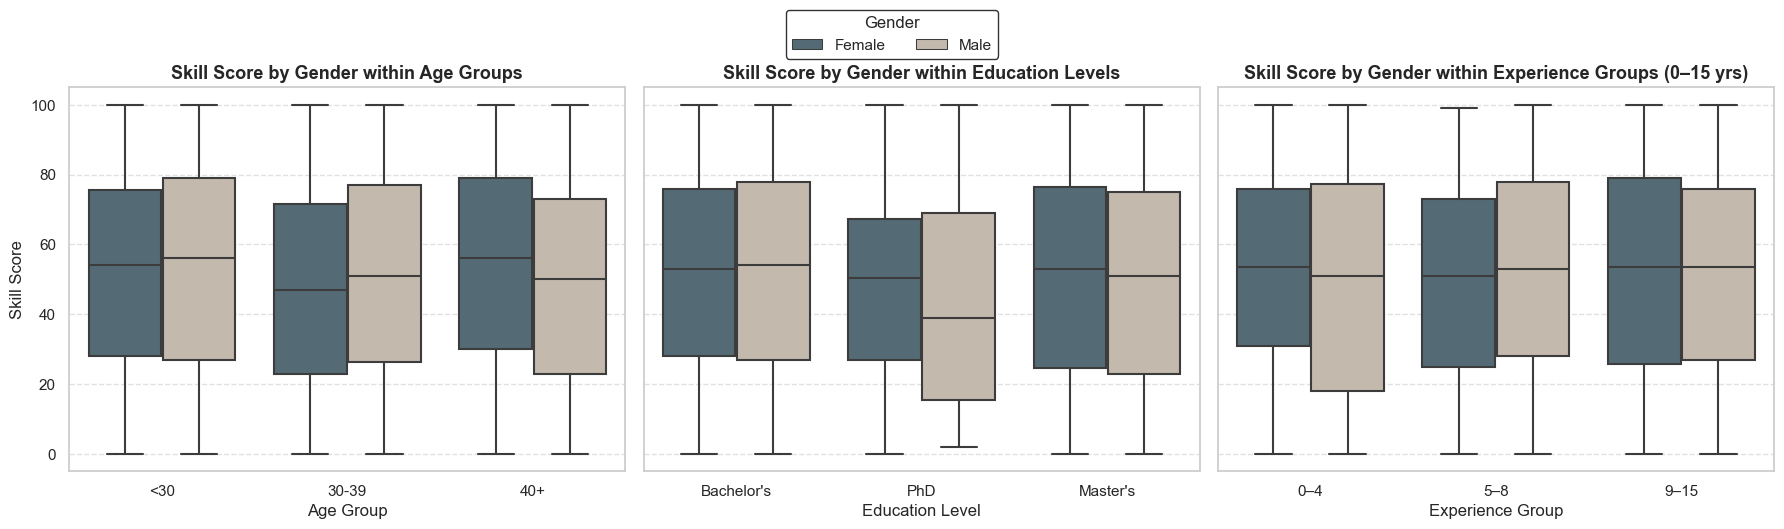

In [68]:
df['experience_group'] = pd.cut(df['experience_years'], bins = [-1, 4, 8, 15], labels = ['0–4', '5–8', '9–15'])

sns.set_theme(style = "whitegrid")
palette_gender = {'Female': '#4f6d7a', 'Male': '#c7b9a9'}

fig, axes = plt.subplots(1, 3, figsize = (18, 5), sharey = True)

# 1) by age group
sns.boxplot(data = df, x = 'age_group', y = 'skill_score', hue = 'gender', palette = palette_gender, hue_order = ['Female', 'Male'], ax = axes[0])
axes[0].set_title("Skill Score by Gender within Age Groups", fontsize = 13, weight = 'bold')
axes[0].set_xlabel("Age Group")
axes[0].set_ylabel("Skill Score")
axes[0].grid(True, axis = 'y', linestyle = '--', alpha = 0.6)

# 2) by education level
sns.boxplot(data = df, x = 'education_level', y = 'skill_score', hue = 'gender', palette = palette_gender, hue_order = ['Female', 'Male'], ax = axes[1])
axes[1].set_title("Skill Score by Gender within Education Levels", fontsize = 13, weight = 'bold')
axes[1].set_xlabel("Education Level")
axes[1].set_ylabel("")
axes[1].grid(True, axis = 'y', linestyle = '--', alpha = 0.6)

# 3) by experience group
sns.boxplot(data = df, x = 'experience_group', y = 'skill_score', hue = 'gender', palette = palette_gender, hue_order = ['Female', 'Male'], ax = axes[2])
axes[2].set_title("Skill Score by Gender within Experience Groups (0–15 yrs)", fontsize = 13, weight = 'bold')
axes[2].set_xlabel("Experience Group")
axes[2].set_ylabel("")
axes[2].grid(True, axis = 'y', linestyle = '--', alpha = 0.6)

# one legend for all subplots
for ax in axes:
    leg = ax.get_legend()
    if leg: ax.legend_.remove()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, title = "Gender", loc = "upper center",
    bbox_to_anchor = (0.5, 1.07), ncol = 2, frameon = True, edgecolor = 'black'
)

plt.tight_layout(rect = [0, 0, 1, 0.98])
plt.show()


### Interview score

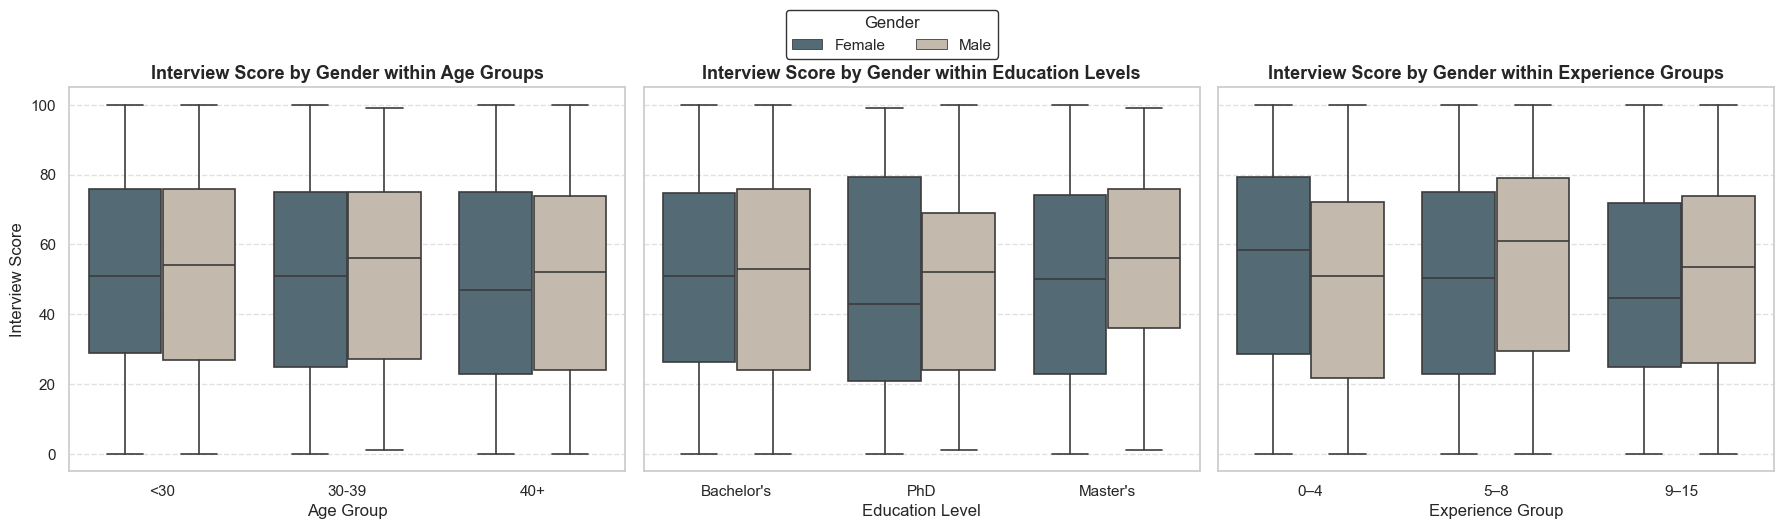

In [69]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize = (18, 5), sharey = True)

# interview score by gender within age groups
sns.boxplot(data = df, x = 'age_group', y = 'interview_score', hue = 'gender', palette = palette_gender, hue_order = ['Female', 'Male'], ax = axes[0], linewidth = 1.2)
axes[0].set_title("Interview Score by Gender within Age Groups", fontsize = 13, weight = 'bold')
axes[0].set_xlabel("Age Group")
axes[0].set_ylabel("Interview Score")
axes[0].grid(True, axis = 'y', linestyle = '--', alpha = 0.6)

# interview score by gender within education level
sns.boxplot(data = df, x = 'education_level', y = 'interview_score', hue = 'gender', palette = palette_gender, hue_order = ['Female', 'Male'], ax = axes[1], linewidth = 1.2)
axes[1].set_title("Interview Score by Gender within Education Levels", fontsize = 13, weight = 'bold')
axes[1].set_xlabel("Education Level")
axes[1].set_ylabel("")
axes[1].grid(True, axis = 'y', linestyle = '--', alpha = 0.6)

# interview score by gender within experience group
sns.boxplot(data = df, x = 'experience_group', y = 'interview_score', hue = 'gender', palette = palette_gender, hue_order = ['Female', 'Male'], ax = axes[2], linewidth = 1.2)
axes[2].set_title("Interview Score by Gender within Experience Groups", fontsize = 13, weight = 'bold')
axes[2].set_xlabel("Experience Group")
axes[2].set_ylabel("")
axes[2].grid(True, axis = 'y', linestyle = '--', alpha = 0.6)

for ax in axes:
    leg = ax.get_legend()
    if leg: ax.legend_.remove()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, title = "Gender", loc = "upper center",
    bbox_to_anchor = (0.5, 1.07), ncol = 2, frameon = True, edgecolor = 'black'
)

plt.tight_layout(rect = [0, 0, 1, 0.98])
plt.show()

Interview scores seem to be pretty balanced between male and female candidates across all groups. Looking at age, education, and experience, there aren’t any clear or consistent differences between genders. The scores tend to line up closely in each category, both in terms of average and range. This suggests that, in this dataset, interview evaluations don’t show signs of systematic gender bias.

### Personality score

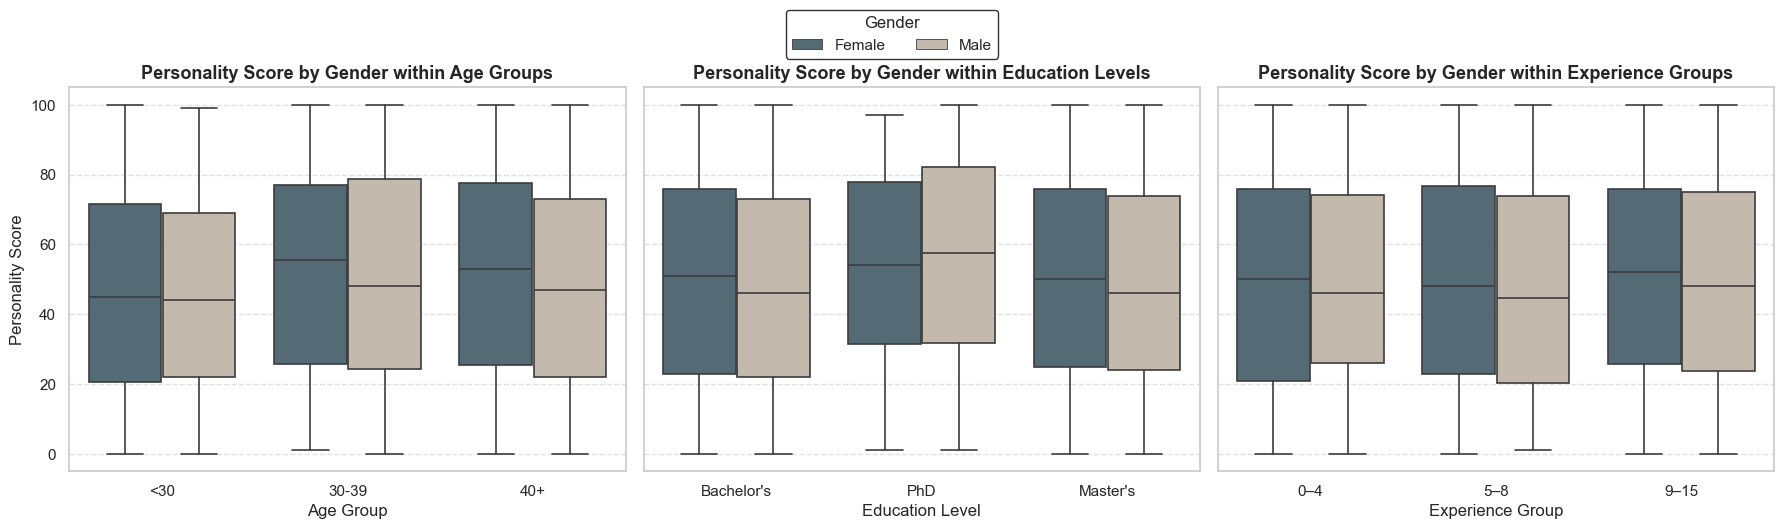

In [70]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize = (18, 5), sharey = True)

# personality score by gender within age groups
sns.boxplot(data = df, x = 'age_group', y = 'personality_score', hue = 'gender', palette = palette_gender, hue_order = ['Female', 'Male'], ax= axes[0], linewidth = 1.2)
axes[0].set_title("Personality Score by Gender within Age Groups", fontsize = 13, weight = 'bold')
axes[0].set_xlabel("Age Group")
axes[0].set_ylabel("Personality Score")
axes[0].grid(True, axis = 'y', linestyle = '--', alpha = 0.6)

# personality score by gender within education level
sns.boxplot(data = df, x = 'education_level', y = 'personality_score', hue = 'gender', palette = palette_gender, hue_order = ['Female', 'Male'], ax = axes[1], linewidth = 1.2)
axes[1].set_title("Personality Score by Gender within Education Levels", fontsize = 13, weight = 'bold')
axes[1].set_xlabel("Education Level")
axes[1].set_ylabel("")
axes[1].grid(True, axis = 'y', linestyle = '--', alpha = 0.6)

# personality score by gender within experience group
sns.boxplot(data = df, x = 'experience_group', y = 'personality_score', hue = 'gender', palette = palette_gender, hue_order = ['Female', 'Male'], ax = axes[2], linewidth = 1.2)
axes[2].set_title("Personality Score by Gender within Experience Groups", fontsize = 13, weight = 'bold')
axes[2].set_xlabel("Experience Group")
axes[2].set_ylabel("")
axes[2].grid(True, axis = 'y', linestyle = '--', alpha = 0.6)

# remove duplicate legends
for ax in axes:
    leg = ax.get_legend()
    if leg: ax.legend_.remove()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, title = "Gender", loc = "upper center",
    bbox_to_anchor = (0.5, 1.07), ncol = 2, frameon = True, edgecolor = 'black'
)

plt.tight_layout(rect = [0, 0, 1, 0.98])
plt.show()

Personality scores are similar for male and female candidates across different age groups, education levels, and experience ranges. In each case, the average scores and overall spread are closely matched, and no group stands out with a consistent difference. This suggests that, in this dataset, personality evaluations don’t show clear signs of gender bias - men and women seem to be rated similarly no matter their background.

## Logistic Regression

To dig deeper into the patterns we've seen so far, I ran a logistic regression to see how different factors - like education, experience, and evaluation scores - relate to the chances of getting hired. I started with a simple model using just the main effects, then added interaction terms to see if the impact of qualifications changes depending on gender. This helps reveal not just whether gender plays a role directly, but also whether strong qualifications are valued differently for men and women.

In [71]:
# defining a logistic regression function

def logistic_regression(X, y):
    X = sm.add_constant(X)
    logit_model = sm.Logit(y, X).fit()
    return logit_model.summary()

**Encoding the object variables:**

In [72]:
df['gender_encoded'] = df['gender'].map({'Male': 0, 'Female': 1})
edu_order = {"Bachelor's": 1, "Master's": 2, "PhD": 3}
df['education_encoded'] = df['education_level'].map(edu_order)

***Without interaction effects***

In [73]:
features = ['gender_encoded', 'age', 'education_encoded', 'experience_years', 'skill_score', 'interview_score', 'personality_score']

logistic_regression(df[features], df['hiring_decision'])

Optimization terminated successfully.
         Current function value: 0.524323
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        hiring_decision   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1492
Method:                           MLE   Df Model:                            7
Date:                Tue, 12 Aug 2025   Pseudo R-squ.:                  0.1531
Time:                        14:08:26   Log-Likelihood:                -786.48
converged:                       True   LL-Null:                       -928.65
Covariance Type:            nonrobust   LLR p-value:                 1.336e-57
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -5.2238      0.403    -12.971      0.000      -6.013      -4.434
gender_encoded       -0.0044      0.124     -0.035      0.972      -0.248       0.239
age                  -0.0028      0.007     -0.411      0.681      -0.016       0.010
education_encoded     0.9444      0.094     10.080      0.000       0.761       1.128
experience_years      0.0717      0.014      5.218      0.000       0.045       0.099
skill_score           0.0197      0.002      8.784      0.000       0.015       0.024
interview_score       0.0150      0.002      6.680      0.000       0.011       0.019
personality_score     0.0146      0.002      6.740      0.000       0.010       0.019
=====================================================================================
"""

In this first model, gender does not have a statistically significant effect on hiring decisions once education, experience, and evaluation scores are accounted for. The p-value for the gender variable is 0.972, suggesting no meaningful difference in hiring outcomes between men and women overall.

Instead, qualifications - particularly education level, years of experience, and scores from the recruitment process (skill, interview, and personality) - are the main drivers of hiring. These findings suggest that when candidates are evaluated solely on their qualifications, there’s no strong evidence of gender bias - consistent with the results of the 2009 study by Isaac, Lee, and Carnes.

***With interaction effects:***

In [74]:
df['gender_x_age'] = df['gender_encoded'] * df['age']
df['gender_x_education'] = df['gender_encoded'] * df['education_encoded']
df['gender_x_experience'] = df['gender_encoded'] * df['experience_years']
df['gender_x_skill'] = df['gender_encoded'] * df['skill_score']
df['gender_x_interview'] = df['gender_encoded'] * df['interview_score']
df['gender_x_personality'] = df['gender_encoded'] * df['personality_score']

full_interaction_features = ['gender_encoded', 'age', 'education_encoded', 'experience_years', 'skill_score', 'interview_score', 'personality_score', 'gender_x_education', 'gender_x_skill', 'gender_x_age', 'gender_x_experience', 'gender_x_interview', 'gender_x_personality']

logistic_regression(df[full_interaction_features], df['hiring_decision'])

Optimization terminated successfully.
         Current function value: 0.521513
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        hiring_decision   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1486
Method:                           MLE   Df Model:                           13
Date:                Tue, 12 Aug 2025   Pseudo R-squ.:                  0.1576
Time:                        14:08:26   Log-Likelihood:                -782.27
converged:                       True   LL-Null:                       -928.65
Covariance Type:            nonrobust   LLR p-value:                 7.845e-55
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -4.7661      0.550     -8.666      0.000      -5.844      -3.688
gender_encoded          -0.9757      0.803     -1.215      0.224      -2.550       0.599
age                     -0.0049      0.009     -0.518      0.605      -0.023       0.014
education_encoded        0.7552      0.126      5.984      0.000       0.508       1.003
experience_years         0.0743      0.019      3.958      0.000       0.037       0.111
skill_score              0.0155      0.003      5.118      0.000       0.010       0.021
interview_score          0.0162      0.003      5.126      0.000       0.010       0.022
personality_score        0.0152      0.003      5.084      0.000       0.009       0.021
gender_x_education       0.4025      0.190      2.123      0.034       0.031       0.774
gender_x_skill           0.0090      0.005      1.989      0.047       0.000       0.018
gender_x_age             0.0033      0.014      0.241      0.809      -0.023       0.030
gender_x_experience     -0.0053      0.028     -0.190      0.849      -0.060       0.049
gender_x_interview      -0.0023      0.005     -0.512      0.609      -0.011       0.007
gender_x_personality    -0.0013      0.004     -0.298      0.766      -0.010       0.007
========================================================================================
"""

This second model includes interaction terms between gender and other predictors, revealing a more nuanced picture. The main effect of gender remains statistically insignificant (p = 0.224), indicating no overall bias against women in the hiring process. However, some interaction effects are significant, specifically:

- The interaction between gender and education (**p = 0.034**)

- The interaction between gender and skill score (**p = 0.047**)

These findings suggest that women benefit more from higher education and stronger skill scores than men do. In other words, once women present strong qualifications, their chances of being hired catch up to - or even exceed - those of men. This pattern points to what could be described as qualification-dependent fairness: gender bias may not appear uniformly but rather fade or reverse when women demonstrate high competence.

## Summary of findings

So far, the results don’t show a consistent gender bias in hiring when we look at the simple comparisons. Men and women tend to have similar skill, interview, and personality scores across different ages, education levels, and years of experience. Hiring decisions seem to be driven mostly by qualifications - especially education, skill, and experience. But when we look at how these factors interact with gender, a more interesting pattern appears: women seem to gain more from having higher education and stronger skill scores than men do. This points to a kind of qualification-dependent fairness, where any gender differences in hiring shrink - or even flip - once women show strong qualifications.

# Reducing Bias by Implementing a Model for Automated Resume Screening

Although the analysis of this dataset did not reveal a consistent or significant gender bias in hiring outcomes, bias can still occur earlier in the recruitment process - before candidates even reach the interview stage. One critical point where bias may creep in is during the initial CV screening phase, where decisions are often made quickly and subjectively. To explore ways of reducing potential bias at this stage, the second part of this project focuses on building a simple pre-screening model that evaluates CVs and classifies them as a “fit” or “not fit” for a given a role's requirements. By standardizing this first step with objective, rule-based criteria, we can help ensure that qualified candidates are considered fairly, regardless of gender.

In [75]:
df_r = pd.read_csv('C:\\Users\\Aleksandar Stojcev\\Desktop\\Tanya DE\\Data Science 2025\\FINAL PROJECT\\data\\resumes.csv')

In [76]:
df_r

,category,resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
161,Testing,Computer Skills: â¢ Proficient in MS office (...
162,Testing,â Willingness to accept the challenges. â ...
163,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
164,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...


Our dataset contains 166 unique resumes, each linked to a specific job category representing the position the applicant applied for.

In the following section, I will present a built simple but effective tool that can automatically screen resumes for a specific job. Instead of reading each resume manually, the model uses natural language processing (NLP) techniques to figure out how well each one matches the job requirements. It works by first cleaning and standardizing the text - removing stopwords, lowercasing, and lemmatizing words so everything is in a consistent format. Then, it turns the text into numbers using ***TF-IDF vectorization***, which gives more weight to important terms and less to common words. Finally, it measures how similar each resume is to the job requirements using ***cosine similarity***. If the score is above a certain threshold, the resume is marked as a **Fit**; otherwise, it’s a **Not Fit**. This method doesn’t require any training data, so it’s quick to set up and easy to adapt to different job roles. It’s not perfect, but it’s a great starting point - and it can be upgraded later with more advanced models like BERT for even smarter matching.

## Model Implementation

In [77]:
def score_resumes_against_jd(jd_text: str, resume_df: pd.DataFrame, threshold: float = 0.05) -> pd.DataFrame:

    # initialize tools
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()

    # preprocessing function 
    def preprocess_text(text):
        text = text.lower()
        text = re.sub(r'\n', ' ', text)
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        tokens = nltk.word_tokenize(text)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    
        return ' '.join(tokens)

    # preprocess resumes
    resume_df = resume_df.copy()
    resume_df["preprocessed_resume"] = resume_df["resume"].apply(preprocess_text)

    # preprocess job description
    preprocessed_jd = preprocess_text(jd_text)

    # combine for TF-IDF vectorization
    combined_texts = resume_df["preprocessed_resume"].tolist() + [preprocessed_jd]
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(combined_texts)

    # separate vectors
    resume_vectors = tfidf_matrix[:-1]
    jd_vector = tfidf_matrix[-1]

    # compute similarity scores
    similarities = cosine_similarity(resume_vectors, jd_vector)

    # add results to DataFrame
    resume_df["similarity_score"] = similarities.flatten()
    resume_df["fit"] = resume_df["similarity_score"].apply(
        lambda x: "Fit" if x >= threshold else "Not Fit"
    )

    # return sorted result
    return resume_df[["category", "preprocessed_resume", "similarity_score", "fit"]].sort_values(by = "similarity_score", ascending = False)

## Model Evaluation

For testing, the next cell contains a short job description for each category in our resume dataset. In the following cell, I loop through all of these job descriptions and run them through the model. For each role, the model returns the top five matching resumes - and the results look sensible, which suggests that the model is performing well.

In [78]:
job_descriptions = {
    "Java Developer": "Seeking a Java developer with experience in building web applications, using Spring Boot, REST APIs, and SQL databases.",
    "Database": "Looking for a database specialist with expertise in relational databases, data modeling, and performance optimization using SQL.",
    "Data Science": "Hiring a data scientist with experience in Python, machine learning, data visualization, and statistical analysis.",
    "Advocate": "Seeking a legal advocate with knowledge of civil law, client consultation, and case preparation.",
    "HR": "Looking for a Human Resources professional to manage recruitment, onboarding, and employee relations. Experience with HRMS systems preferred.",
    "DotNet Developer": "Hiring a .NET Developer with strong C#, ASP.NET, MVC, and SQL skills for web application development.",
    "Hadoop": "Seeking a Hadoop developer to design and optimize big data workflows using HDFS, Hive, Pig, and Spark.",
    "DevOps Engineer": "Looking for a DevOps engineer with experience in CI/CD, Docker, Kubernetes, Jenkins, and cloud platforms like AWS or Azure.",
    "Automation Testing": "Seeking a QA Automation Engineer proficient in Selenium, TestNG, and scripting languages such as Python or Java.",
    "Testing": "Hiring a software tester experienced in manual and automated testing, test case creation, and bug tracking tools.",
    "Civil Engineer": "Looking for a civil engineer to manage construction projects, site supervision, and structural design using AutoCAD and STAAD Pro.",
    "Business Analyst": "Seeking a business analyst skilled in requirements gathering, stakeholder communication, and tools like Jira, Excel, and Power BI.",
    "SAP Developer": "Hiring an SAP Developer experienced in ABAP, SAP modules (FI/CO/MM/SD), and system integration.",
    "Health and Fitness": "Looking for a health and fitness coach with experience in personal training, nutrition planning, and client motivation.",
    "Python Developer": "Hiring a Python developer with experience in Django or Flask, REST APIs, and PostgreSQL.",
    "Arts": "Seeking an arts professional for creative roles in graphic design, visual arts, or performing arts. Portfolio required.",
    "Electrical Engineering": "Looking for an electrical engineer with knowledge in circuit design, PLC programming, and power systems.",
    "Sales": "Hiring a sales executive to drive B2B/B2C sales, build client relationships, and achieve revenue targets.",
    "Network Security Engineer": "Seeking a network security expert skilled in firewalls, intrusion detection systems, and cybersecurity best practices.",
    "Mechanical Engineer": "Hiring a mechanical engineer with experience in CAD, manufacturing processes, and mechanical system design.",
    "ETL Developer": "Looking for an ETL developer to build data pipelines using tools like Informatica, Talend, or SSIS and strong SQL skills.",
    "Blockchain": "Seeking a blockchain developer with experience in smart contracts, Solidity, Ethereum, and decentralized applications.",
    "Operations Manager": "Hiring an operations manager to oversee daily processes, improve efficiency, and manage cross-functional teams.",
    "Web Designing": "Looking for a web designer with HTML, CSS, JavaScript, and UI/UX design experience. Portfolio preferred.",
    "PMO": "Hiring a Project Management Officer to support project planning, tracking, risk management, and reporting."
}


In [79]:
for role, jd_text in job_descriptions.items():
    results = score_resumes_against_jd(jd_text, df_r)
    num_fit = results["fit"].value_counts().get("Fit", 0)
    
    print(f"\n=== Role: {role} ===")
    print(f"Top 5 Matches:")
    display(results.head(5))
    print(f"\nNumber of resumes classified as 'Fit': {num_fit} out of {len(results)}")


=== Role: Java Developer ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
70,Java Developer,computer skill language script jsp servlet htm...,0.192781,Fit
71,Java Developer,education detail january 2016 information tech...,0.178026,Fit
72,Java Developer,technical skill programming language java serv...,0.175162,Fit
106,Python Developer,technical skill language python python framewo...,0.161125,Fit
68,Java Developer,technicalskills springmvc hibernate jdbc java ...,0.144349,Fit



Number of resumes classified as 'Fit': 47 out of 166

=== Role: Database ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
130,Database,technical skill database oracle rdbms 10g 11g ...,0.190194,Fit
131,Database,software skill rdbms m sql server 200020052008...,0.186292,Fit
133,Database,education detail may 2011 may 2014 bachelor sc...,0.182854,Fit
125,Database,technical expertise operating system microsoft...,0.162365,Fit
129,Database,technical skill operating system linux window ...,0.139372,Fit



Number of resumes classified as 'Fit': 31 out of 166

=== Role: Data Science ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
6,Data Science,skill python tableau data visualization r stud...,0.437877,Fit
9,Data Science,expertise data quantitative analysis decision ...,0.304631,Fit
7,Data Science,education detail btech rayat bahra institute e...,0.233076,Fit
8,Data Science,personal skill ability quickly grasp technical...,0.225554,Fit
134,Database,technical skill sql oracle v10 v11 v12 r progr...,0.165831,Fit



Number of resumes classified as 'Fit': 31 out of 166

=== Role: Advocate ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
22,Advocate,education detail llb dibrugarh university advo...,0.347519,Fit
27,Advocate,skill legal writing efficient researcher legal...,0.282574,Fit
23,Advocate,education detail november 2016 january 2019 ll...,0.242468,Fit
24,Advocate,skill know english native speaker ielts overal...,0.212276,Fit
57,Civil Engineer,education detail january 2005 ssc baramati mah...,0.190733,Fit



Number of resumes classified as 'Fit': 20 out of 166

=== Role: HR ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
11,HR,skill window xp m office word excel lookup piv...,0.109176,Fit
122,PMO,area expertise profile around 10 plus year pro...,0.078723,Fit
14,HR,education detail bba lovely professional unive...,0.077271,Fit
10,HR,technical skill typewriting tora spsseducation...,0.067797,Fit
114,DevOps Engineer,total experience 15 year core expertise data b...,0.062247,Fit



Number of resumes classified as 'Fit': 8 out of 166

=== Role: DotNet Developer ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
153,DotNet Developer,technical skill programming language cnet web ...,0.379277,Fit
151,DotNet Developer,technology aspnet mvc 304050 unit testing enti...,0.290552,Fit
149,DotNet Developer,technical skill language c asp net mvc html cs...,0.236385,Fit
147,DotNet Developer,technical skill web technology asp net html cs...,0.224368,Fit
152,DotNet Developer,technical skill category skill language c c oo...,0.189787,Fit



Number of resumes classified as 'Fit': 38 out of 166

=== Role: Hadoop ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
135,Hadoop,education detail hadoop developer hadoop devel...,0.504821,Fit
137,Hadoop,operating systemslinux ubuntu window 200708 to...,0.341971,Fit
139,Hadoop,technical skill set programming language apach...,0.312353,Fit
136,Hadoop,skill set hadoop map reduce hdfs hive sqoop ja...,0.288737,Fit
141,Hadoop,technical skill set big data ecosystem hadoop ...,0.278570,Fit



Number of resumes classified as 'Fit': 15 out of 166

=== Role: DevOps Engineer ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
109,DevOps Engineer,skill visa b1visa usa onsite visit sweden u se...,0.186995,Fit
111,DevOps Engineer,core competency ant maven git bitbucket jenkin...,0.123435,Fit
60,Civil Engineer,computer knowledge drafting tool autocad packa...,0.090929,Fit
115,DevOps Engineer,technical skill hp alm rtc jira as400 iseries ...,0.076508,Fit
7,Data Science,education detail btech rayat bahra institute e...,0.072919,Fit



Number of resumes classified as 'Fit': 11 out of 166

=== Role: Automation Testing ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
89,Automation Testing,technical skill automation testing selenium we...,0.293559,Fit
93,Automation Testing,technical skill language core java automation ...,0.183156,Fit
90,Automation Testing,skill agile methodology scrum kanban extreme p...,0.164728,Fit
108,Python Developer,operating system window others m excel m offic...,0.123689,Fit
105,Python Developer,technical proficiency platform ubuntufedoracen...,0.120147,Fit



Number of resumes classified as 'Fit': 36 out of 166

=== Role: Testing ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
92,Automation Testing,education detail btech electronics instrumenta...,0.430648,Fit
93,Automation Testing,technical skill language core java automation ...,0.270422,Fit
90,Automation Testing,skill agile methodology scrum kanban extreme p...,0.254710,Fit
165,Testing,skill set o window xp788110 database mysql sql...,0.212201,Fit
77,Business Analyst,key skill requirement gathering requirement an...,0.195818,Fit



Number of resumes classified as 'Fit': 21 out of 166

=== Role: Civil Engineer ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
60,Civil Engineer,computer knowledge drafting tool autocad packa...,0.350406,Fit
57,Civil Engineer,education detail january 2005 ssc baramati mah...,0.319173,Fit
61,Civil Engineer,personal skill passionate towards learning new...,0.274753,Fit
58,Civil Engineer,skill 1autocad 2pro v 3catia 4word excel 5phot...,0.243734,Fit
56,Civil Engineer,education detail civil engineering civil engin...,0.188398,Fit



Number of resumes classified as 'Fit': 12 out of 166

=== Role: Business Analyst ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
75,Business Analyst,education detail computer science mumbai mahar...,0.154138,Fit
78,Business Analyst,skill area exposure modeling tool bizagi m vis...,0.149705,Fit
79,Business Analyst,technological skill knowledge computer window ...,0.146458,Fit
77,Business Analyst,key skill requirement gathering requirement an...,0.137033,Fit
123,PMO,skill exceptional communication networking ski...,0.125064,Fit



Number of resumes classified as 'Fit': 19 out of 166

=== Role: SAP Developer ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
86,SAP Developer,education detail sap technical architect sap t...,0.478516,Fit
84,SAP Developer,education detail may 2013 master computer appl...,0.278137,Fit
85,SAP Developer,education detail january 2016 bachelor enginee...,0.249662,Fit
3,Data Science,skill r python sap hana tableau sap hana sql s...,0.203096,Fit
82,SAP Developer,competency sap business intelligence version s...,0.183477,Fit



Number of resumes classified as 'Fit': 11 out of 166

=== Role: Health and Fitness ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
55,Health and fitness,education detail may 2014 diploma nutrition ed...,0.242779,Fit
53,Health and fitness,skill computer easily operate operating system...,0.233316,Fit
50,Health and fitness,education detail january 1992 january 2003 fir...,0.217909,Fit
51,Health and fitness,education detail january 2018 m nutrition exer...,0.214942,Fit
54,Health and fitness,education detail january 2009 pg sport science...,0.187003,Fit



Number of resumes classified as 'Fit': 14 out of 166

=== Role: Python Developer ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
106,Python Developer,technical skill language python python framewo...,0.270101,Fit
103,Python Developer,technical skill responsibility hand experience...,0.162009,Fit
105,Python Developer,technical proficiency platform ubuntufedoracen...,0.130243,Fit
108,Python Developer,operating system window others m excel m offic...,0.117647,Fit
124,Database,technical expertise db language sql database t...,0.094012,Fit



Number of resumes classified as 'Fit': 14 out of 166

=== Role: Arts ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
32,Arts,additional qualification april 2000 web design...,0.194415,Fit
31,Arts,operating system window xp vista 07education d...,0.191042,Fit
33,Arts,education detail january 2017 rachana sansad s...,0.165939,Fit
35,Arts,skill courseskill name board year passing grad...,0.147943,Fit
34,Arts,education detail august 2018 january 2021 ente...,0.116627,Fit



Number of resumes classified as 'Fit': 12 out of 166

=== Role: Electrical Engineering ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
94,Electrical Engineering,skill 1 mc office 2 autocad 2016 3 introductor...,0.250494,Fit
98,Electrical Engineering,education detail january 2012 january 2013 ele...,0.224061,Fit
97,Electrical Engineering,education detail july 2016 may 2019 electrical...,0.205528,Fit
96,Electrical Engineering,achievement oriented people management skill a...,0.200207,Fit
88,Automation Testing,social skill ability establish trust work team...,0.171830,Fit



Number of resumes classified as 'Fit': 22 out of 166

=== Role: Sales ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
47,Sales,key skill planning strategizing presentation s...,0.332637,Fit
46,Sales,skill 1 msoffice 2 good communication skill co...,0.206500,Fit
48,Sales,skill m office photoshop sql servereducation d...,0.163798,Fit
53,Health and fitness,skill computer easily operate operating system...,0.134397,Fit
113,DevOps Engineer,core skill project program management agile sc...,0.132993,Fit



Number of resumes classified as 'Fit': 12 out of 166

=== Role: Network Security Engineer ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
117,Network Security Engineer,skill set cisco certified network associate cc...,0.190514,Fit
119,Network Security Engineer,technical expertise cisco asa checkpoint firew...,0.182654,Fit
118,Network Security Engineer,communication skill writing skill english good...,0.159433,Fit
116,Network Security Engineer,skill set experience implementing troubleshoot...,0.132899,Fit
120,Network Security Engineer,operating system window linux ubuntu network t...,0.083006,Fit



Number of resumes classified as 'Fit': 7 out of 166

=== Role: Mechanical Engineer ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
43,Mechanical Engineer,education detail june 2014 june 2018 mechanica...,0.329438,Fit
42,Mechanical Engineer,education detail january 2018 bachelor enginee...,0.264737,Fit
40,Mechanical Engineer,education detail may 1999 september 2002 diplo...,0.205143,Fit
44,Mechanical Engineer,im hard working person im self confident mould...,0.190495,Fit
41,Mechanical Engineer,skill knowledge software computer auto cad inc...,0.169845,Fit



Number of resumes classified as 'Fit': 15 out of 166

=== Role: ETL Developer ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
145,ETL Developer,skill set talend big data informatica power ce...,0.324574,Fit
143,ETL Developer,technicalproficiencies db oracle 11g domain in...,0.266274,Fit
142,ETL Developer,technical summary knowledge informatica power ...,0.258855,Fit
144,ETL Developer,education detail january 2015 bachelor enginee...,0.235139,Fit
146,ETL Developer,computer skill yes sql knowledgeyes unix knowl...,0.201033,Fit



Number of resumes classified as 'Fit': 34 out of 166

=== Role: Blockchain ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
157,Blockchain,software skill language c c java operating sys...,0.376453,Fit
155,Blockchain,skill strong c fundamental problem solving eth...,0.261243,Fit
154,Blockchain,hobby playing chess solving rubiks cube watchi...,0.210907,Fit
156,Blockchain,key skill programing language c c python apex ...,0.141669,Fit
158,Blockchain,skill bitcoin ethereum solidity hyperledger be...,0.111951,Fit



Number of resumes classified as 'Fit': 8 out of 166

=== Role: Operations Manager ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
100,Operations Manager,key competency multi operation managementpeopl...,0.206288,Fit
99,Operations Manager,education detail bca vinayaka mission universi...,0.172294,Fit
123,PMO,skill exceptional communication networking ski...,0.108881,Fit
121,PMO,core competency maintain process ensure projec...,0.101844,Fit
78,Business Analyst,skill area exposure modeling tool bizagi m vis...,0.086687,Fit



Number of resumes classified as 'Fit': 14 out of 166

=== Role: Web Designing ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
157,Blockchain,software skill language c c java operating sys...,0.107688,Fit
37,Web Designing,education detail bca bachelor computer applica...,0.105491,Fit
39,Web Designing,skill language c basic java basic web technolo...,0.104230,Fit
38,Web Designing,education detail january 2016 bsc information ...,0.102409,Fit
71,Java Developer,education detail january 2016 information tech...,0.090964,Fit



Number of resumes classified as 'Fit': 18 out of 166

=== Role: PMO ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
121,PMO,core competency maintain process ensure projec...,0.223222,Fit
122,PMO,area expertise profile around 10 plus year pro...,0.212018,Fit
113,DevOps Engineer,core skill project program management agile sc...,0.152739,Fit
99,Operations Manager,education detail bca vinayaka mission universi...,0.133991,Fit
77,Business Analyst,key skill requirement gathering requirement an...,0.111413,Fit



Number of resumes classified as 'Fit': 38 out of 166


In the next cell, you can experiment with different job descriptions. Feel free to write your own or use examples you find online.

In [80]:
job_description = ""

results_df = score_resumes_against_jd(job_description, df_r)
results_df.head(10)

,category,preprocessed_resume,similarity_score,fit
0,Data Science,skill programming language python panda numpy ...,0.0,Not Fit
104,Python Developer,education detail june 2013 june 2016 diploma c...,0.0,Not Fit
106,Python Developer,technical skill language python python framewo...,0.0,Not Fit
107,Python Developer,training attended 1 successfully completed esd...,0.0,Not Fit
108,Python Developer,operating system window others m excel m offic...,0.0,Not Fit
109,DevOps Engineer,skill visa b1visa usa onsite visit sweden u se...,0.0,Not Fit
110,DevOps Engineer,software proficiency language basic c sql plsq...,0.0,Not Fit
111,DevOps Engineer,core competency ant maven git bitbucket jenkin...,0.0,Not Fit
112,DevOps Engineer,technical skill key skill m technology net sha...,0.0,Not Fit
113,DevOps Engineer,core skill project program management agile sc...,0.0,Not Fit


In [81]:
results_df["fit"].value_counts()

fit
Not Fit    166
Name: count, dtype: int64

# Conclusion

This project explored two related areas: understanding whether gender bias influences hiring decisions and developing a tool to help screen resumes automatically. The analysis of a hiring dataset showed that, on the surface, men and women performed similarly in skills, interviews, and personality across various ages, education levels, and years of experience. A closer look, however, revealed an interesting trend - women appeared to benefit more than men from having higher education and stronger skill scores, with gender gaps in hiring narrowing or even reversing when these qualifications were present. This suggests that while qualifications are a key driver of hiring decisions, their interaction with gender can reveal more subtle patterns.

The second part of the project involved creating a resume screening tool that uses TF-IDF vectorization and cosine similarity to compare job descriptions with resumes and rank candidates by relevance. The tool performed well across different job roles, showing that even a simple and explainable method can be effective as a first step in the screening process.

Together, these findings highlight how data-driven approaches can make recruitment more efficient while also encouraging awareness of fairness in hiring. The combination of automation and thoughtful analysis offers a practical way to streamline candidate selection while keeping potential biases in view.

# Limitation and Future Research

This project has several limitations that should be considered when interpreting the results. First, the hiring dataset was limited in scope and did not include certain variables that could provide deeper insights into potential bias, such as salary expectations, specific job role types (e.g., male-dominated vs. female-dominated roles), or the gender of the hiring manager. These factors have been explored in other studies (Isaac et al., 2009, Friedmann & Efrat-Treister, 2021, Galos & Coppock, 2023) and could be valuable additions for future research.

The resume screening model also has its constraints. It works best with job descriptions that are fairly standardized and focused on clear, concrete requirements. Many job descriptions found online are vague or overly broad, which can lead to less accurate matching. In such cases, lowering the similarity threshold can help, but ideally, the tool would be used with job descriptions that are consistent in structure and content. Future improvements could focus on handling varied job description styles more effectively, possibly through more advanced natural language understanding techniques.

# References

Bamieh, O., & Ziegler, L. (2023). Gender-age differences in hiring rates and prospective wages—Evidence from job referrals to unemployed workers. Labour Economics, 83, 102395. https://doi.org/10.1016/j.labeco.2023.102395

Dutta, G. (2020). Resume dataset [Dataset]. Kaggle. https://www.kaggle.com/datasets/gauravduttakiit/resume-dataset

Eagly, A. H., & Karau, S. J. (2002). Role congruity theory of prejudice toward female leaders. Psychological Review, 109(3), 573–598. https://doi.org/10.1037/0033-295X.109.3.573

El Kharoua, R. (2023). Predicting hiring decisions in recruitment data [Dataset]. Kaggle. https://www.kaggle.com/datasets/rabieelkharoua/predicting-hiring-decisions-in-recruitment-data

Friedmann, E., & Efrat-Treister, D. (2021). Gender bias in STEM hiring: Implicit in-group gender favoritism among men managers. Gender & Society, 37(1), 85–109. https://doi.org/10.1177/0891243221137910

Galos, D. R., & Coppock, A. (2023). Gender composition predicts gender bias: A meta-reanalysis of hiring discrimination audit experiments. Science Advances, 9(18), eade7979. https://doi.org/10.1126/sciadv.ade7979

González, M. J., Cortina, C., & Rodríguez, J. (2019). The role of gender stereotypes in hiring: A field experiment. European Sociological Review, 35(2), 187–204. https://doi.org/10.1093/esr/jcy055

Isaac, C., Lee, B., & Carnes, M. (2009). Interventions that affect gender bias in hiring: A systematic review. Academic Medicine, 84(10), 1440–1446. https://doi.org/10.1097/ACM.0b013e3181b6ba00

Moss-Racusin, C. A., Dovidio, J. F., Brescoll, V. L., Graham, M. J., & Handelsman, J. (2012). Science faculty’s subtle gender biases favor male students. Proceedings of the National Academy of Sciences, 109(41), 16474–16479. https://doi.org/10.1073/pnas.1211286109

Park, S. Y., & Oh, E. (2025). Getting a foot in the door: A meta-analysis of U.S. audit studies of gender bias in hiring. Sociological Science. https://doi.org/10.15195/v12.a2

Reiners, B. (2024, August 29). What is gender bias in the workplace? Built In. https://builtin.com/articles/gender-bias-in-the-workplace

Ruggs, E. N., Hebl, M. R., Walker, S. S., & Fa-Kaji, N. (2014). Selection biases that emerge when age meets gender. Journal of Managerial Psychology, 29(8), 1028–1043. https://doi.org/10.1108/JMP-07-2012-0204